# RGQFT Multiplier

This program simulates a quantum circuit for binary multiplication using the quantum Fourier transform using Qiskit. \
Author: Michal Forgó \
Time: 02.14.2025 \
Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.

## 1. Introduction
The DraperQFTAdder is a quantum circuit designed for efficient addition using the Quantum Fourier Transform (QFT). This document explains the logic, structure, and step-by-step implementation of the circuit from fundamental principles to the final construction.

## RGQFT Multiplier
### Quantum Fourier Transform-Based Multiplication

The **RGQFT Multiplier** leverages the **Quantum Fourier Transform (QFT)** to perform multiplication by encoding multiplicands in quantum registers and manipulating them in the frequency domain. Unlike classical multipliers that rely on sequential carry propagation, this approach applies **controlled phase rotations** to accumulate the product directly in phase space.

The process involves the following steps:

1. **Encoding Multiplicands:**  
   Two input registers, `regA` and `regB`, store the multiplicands, while a third register, `regC`, holds the product (or partial product) bits.

2. **Applying Controlled Phase Shifts:**  
   For every combination of control qubits from `regA` and `regB` and for each target qubit in `regC`, a two-controlled phase gate is applied. The phase shift is calculated as:
   $$
   \lambda = \frac{2\pi}{2^{(control1 + control2 + target - 2\,\text{maxInputLength})}}
   $$
   This formula ensures that the phase contribution from each bit is appropriately weighted by its significance.

3. **Circuit Implementation:**  
   A triple nested loop structure is used:
   - **Outer Loops:** Iterate over all possible control qubits in `regA` and `regB` (with reversed indexing to align the most significant bits correctly).
   - **Inner Loop:** Iterates over each target qubit in `regC` to apply the phase shift.
   
   For each iteration, the two-controlled phase gate acts on:
   - **Control qubit from `regA`:** at index `maxInputLength - control1`
   - **Control qubit from `regB`:** at index `maxInputLength - control2`
   - **Target qubit from `regC`:** at index `target - 1`

---

### Quantum Circuit Representation

In the RGQFT multiplier, the quantum circuit structure is as follows:

- **Control Qubits from `regA` and `regB`:**  
  Each qubit is selected in reverse order to match the correct weight, ensuring the higher-order bits contribute more significantly to the phase.

- **Target Qubits from `regC`:**  
  The controlled phase rotations are applied here, accumulating the product information in the Fourier domain.

- **Two-Controlled Phase Gate:**  
  A crucial component that applies the calculated phase shift `λ` to the target qubit, conditioned on the state of both control qubits.

A conceptual diagram (not shown here) would illustrate the nested-loop interactions, with controlled phase gates linking the registers in a systematic manner.

---

### Quantum Gates Used

#### Two-Controlled Phase (`CP2`) Gate
- **Purpose:**  
  Applies a phase rotation `λ` on a target qubit, conditioned on the state of two control qubits.

- **Phase Calculation:**  
  $$
  \lambda = \frac{2\pi}{2^{(control1 + control2 + target - 2\,\text{maxInputLength})}}
  $$
  This ensures that the phase applied corresponds accurately to the weight of the bits being multiplied.

- **Qubit Assignment:**  
  - **Control from `regA`:** selected as `regA[maxInputLength - control1]`
  - **Control from `regB`:** selected as `regB[maxInputLength - control2]`
  - **Target from `regC`:** selected as `regC[target - 1]`

This gate is central to the multiplication process, combining phase contributions from both operands in the Fourier domain.

---

### Advantages of the RGQFT Multiplier
- **Efficient Multiplication:**  
  By avoiding classical carry propagation and working directly in the Fourier domain, the multiplier achieves efficient computation.

- **Quantum Arithmetic:**  
  This method is particularly suited for quantum algorithms that require modular arithmetic or complex multiplication routines.

- **Scalability:**  
  The structured approach using controlled-phase rotations allows the circuit to scale efficiently with the number of qubits, making it a promising technique for larger quantum systems.

The RGQFT Multiplier showcases how **quantum phase manipulation** can be harnessed to perform arithmetic operations efficiently, forming a vital component in the toolkit of quantum computing.


## 3. Code

### 3.1 Setup
Firstly, we need to import the necessary libraries for the program to work. If you already hasn't done install the requirements.txt or enviroment.yml.

In [28]:
import math
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, RGQFTMultiplier
from qiskit.circuit.library.standard_gates import PhaseGate

After that, the program needs an input method. We can hard-code the
values or we could let the user choose. It doesn’t matter which method we use. We just need to ensure that the input consists only of ones and zeros and that it is not too large so the simulation doesn't take too long. We set the maximum allowed bit length to 7.

In [29]:
#firstBinaryNumber = "1010"
#secondBinaryNumber = "110"

while True:
    firstBinaryNumber = input("Enter a 7-bit or less binary number: ")
    secondBinaryNumber = input("Enter another 7-bit or less binary number: ")

    if len(firstBinaryNumber) > 8 or len(secondBinaryNumber) > 8 or \
    not set(firstBinaryNumber).issubset({'0','1'}) or not set(secondBinaryNumber).issubset({'0','1'}):
        print("Please enter valid inputs. Try again.")
    else:
        break

Before constructing the quantum circuit for multiplication, the algorithm first ensures that both numbers have the same number of digits (or bits). This is done by:

1. **Equalizing the Input Lengths:**
   - The algorithm compares the lengths of the two binary numbers. If `firstBinaryNumber` is shorter than `secondBinaryNumber`, they are swapped so that `firstBinaryNumber` always holds the longer (or equal) number.
   - The shorter number (`secondBinaryNumber`) is then padded with leading zeros until both numbers have the same length.
   - The common length is stored in `maxInputLength`, which is used to determine the size of the input registers (`regA` and `regB`).

2. **Calculating the Number of Output Digits (`outputDigits`):**
   - The product of two numbers with `maxInputLength` digits can be as large as the square of the largest number representable with `maxInputLength` digits.
   - To determine the number of binary digits required to represent the product, the code computes:
     $$
     \text{outputDigits} = \lfloor \log_2(\text{maxInputLength}^2) \rfloor + 1
     $$
   - **Explanation of the Calculation:**
     - **`maxInputLength²`:**  
       This term represents an upper bound on the product's value, based solely on the length of the input numbers.
     - **`log₂(maxInputLength²)`:**  
       Taking the logarithm base 2 gives an estimate of the number of bits needed to represent this upper bound.
     - **`floor(...) + 1`:**  
       The `floor` function rounds this value down to the nearest integer, and adding 1 ensures that there is enough room (i.e., enough binary digits) to represent the product in full, including its most significant bit.


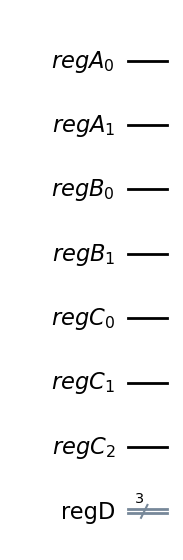

In [30]:
if len(firstBinaryNumber) < len(secondBinaryNumber):
    firstBinaryNumber, secondBinaryNumber = secondBinaryNumber, firstBinaryNumber

secondBinaryNumber = "0" * (len(firstBinaryNumber) - len(secondBinaryNumber)) + secondBinaryNumber
maxInputLength = len(firstBinaryNumber)
outputDigits = math.floor(math.log2(maxInputLength**2))+1

regA = QuantumRegister(maxInputLength, "regA")
regB = QuantumRegister(maxInputLength, "regB")
regC = QuantumRegister(outputDigits, "regC")
regD = ClassicalRegister(outputDigits, "regD")
qc = QuantumCircuit(regA, regB, regC, regD, name="qc")

qc.draw("mpl")

- **`regA`** (Quantum Register, `maxInputLength` qubits)
  - This register stores the first binary number.
  - Each qubit represents a bit of the input, initialized in the `|0⟩` or `|1⟩` state based on the binary number.
  
- **`regB`** (Quantum Register, `maxInputLength` qubits)
  - This register stores the second binary number.
  - Each qubit represents a bit of the input, initialized in the `|0⟩` or `|1⟩` state based on the binary number.

- **`regC`** (Quantum Register, `outputDigits` qubits)
  - This register stores the output of the multiplication.
  - Each qubit represents a bit of the output, initialized in the `|0⟩` state.
   
- **`regD`** (Classical Register, `outputDigits` bits)
  - This is a classical register used to store the final measured result.

Right now, the registers are empty. So we need to put our data in them.
Because all of the individual qbits are set to |0⟩ as default we just need to
use the NOT gate on the qbits that we want to flip into |1⟩.

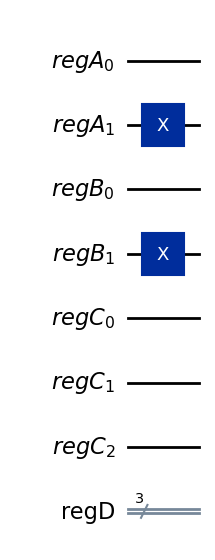

In [31]:
for idx, val in enumerate(firstBinaryNumber):
    if val == "1":
        qc.x(regA[maxInputLength - (idx + 1)])
for idx, val in enumerate(secondBinaryNumber):
    if val == "1":
        qc.x(regB[maxInputLength - (idx + 1)])
qc.draw("mpl")

#### 3.2.1 QFT
##### Outer Loop (`target` qubits in `regB`)

- The loop iterates **backward** over all qubits in `regB` (from highest to lowest index).
- A **Hadamard gate (`H`)** is applied to each `target` qubit, transforming it into an **equal superposition** of `|0⟩` and `|1⟩` states.
- This step is **crucial** for preparing the qubits to encode phase relationships.

##### Inner Loop (`control` qubits in `regB`)

- For each `target` qubit, a nested loop iterates **backward** over all preceding qubits (`control`).
- The loop applies a **controlled-phase (`cp`) gate** between the `target` and each `control` qubit.
- The controlled phase shift `λ` is computed as $\pi$ divided by the 2 to the power of the diference between the indexes `target` and `control`

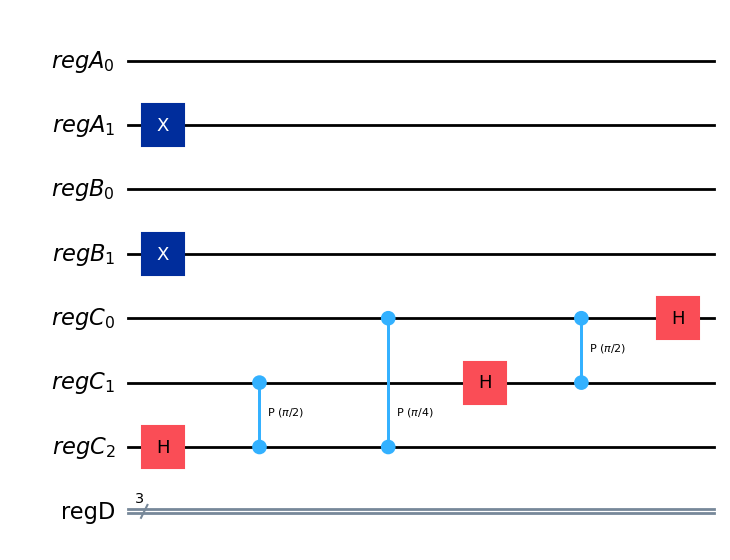

In [32]:
for target in range(maxInputLength, -1, -1):
    qc.h(regC[target])
    for control in range(target-1, -1, -1):
        qc.cp(math.pi*(2**(control-target)), regC[target], regC[control])
qc.barrier()
qc.draw("mpl", plot_barriers=False)

#### 3.2.2 Multiplier
##### Outer Loops (Control Qubits from `regA` and `regB`)
- **Loop over `control1`:**
  - Iterates from 1 to `maxInputLength`.
  - Selects a control qubit from `regA` using the index `maxInputLength - control1` (to account for bit significance).
  
- **Loop over `control2`:**
  - Iterates from 1 to `maxInputLength`.
  - Selects a control qubit from `regB` using the index `maxInputLength - control2`.
  
These two loops ensure that every combination of control qubits from the two registers is considered.

##### Inner Loop (Target Qubits from `regC`)
- **Loop over `target`:**
  - Iterates from 1 to `outputDigits`.
  - Chooses a target qubit from `regC` using the index `target - 1`.
  
This loop applies the phase shift to each appropriate qubit in the output register.

##### Phase Calculation and Gate Application
- **Phase Computation:**
  - The phase shift `λ` is computed as:
    $$
    \lambda = \frac{2\pi}{2^{(control1 + control2 + target - 2\,\text{maxInputLength})}}
    $$
  - This formula adjusts the phase based on the indices of the control and target qubits, ensuring proper scaling within the quantum Fourier transform framework.
  
- **Gate Application:**
  - A two-controlled phase gate (`PhaseGate(λ).control(2)`) is appended to the circuit `qc`.
  - The gate acts on three qubits:
    - **Control from `regA`:** at index `maxInputLength - control1`
    - **Control from `regB`:** at index `maxInputLength - control2`
    - **Target from `regC`:** at index `target - 1`
  
This controlled phase operation is a crucial step in the multiplier circuit, combining contributions from both control registers to affect the target register in the quantum Fourier domain.


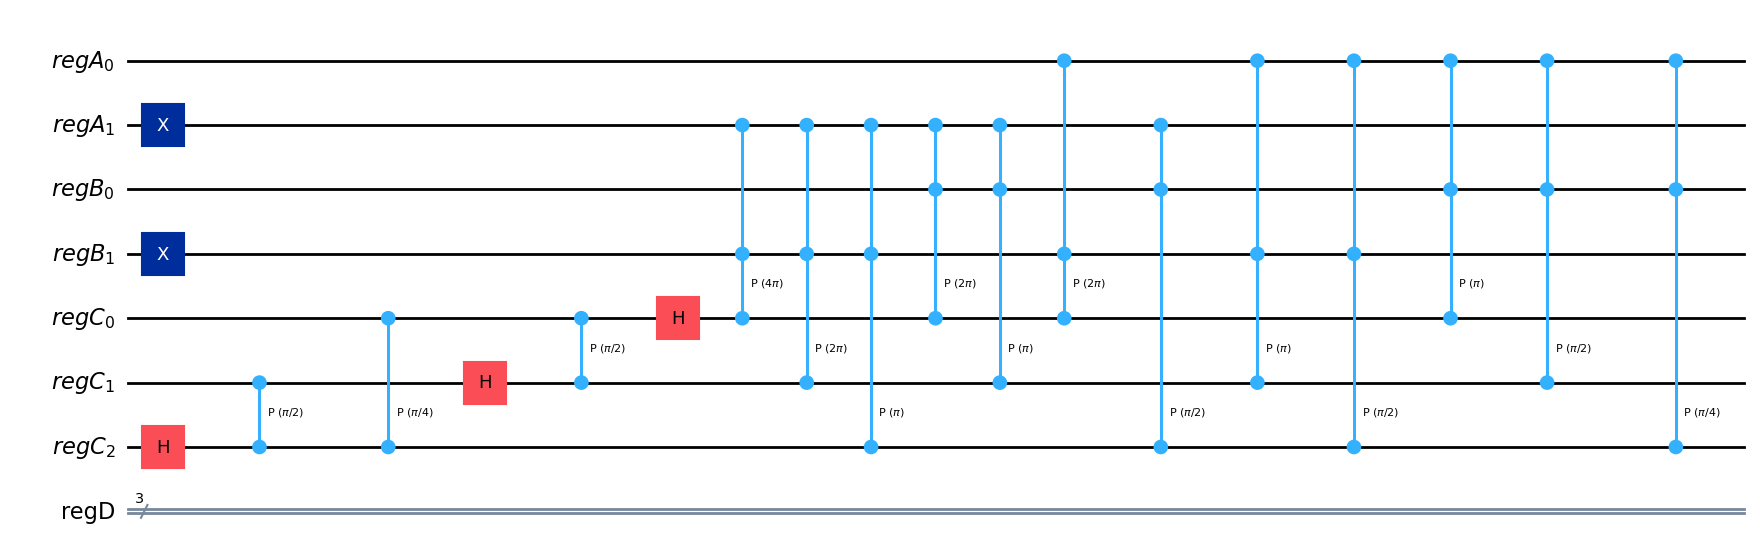

In [33]:
for control1 in range(1, maxInputLength + 1):
    for control2 in range(1, maxInputLength + 1):
        for target in range(1, outputDigits + 1):
            lam = (2 * math.pi) / (2 ** (control2 + control1 + target - 2 * maxInputLength))
            qc.append(
                PhaseGate(lam).control(2),
                [regA[maxInputLength - control1], regB[maxInputLength - control2], regC[target - 1]],
            )
qc.barrier()
qc.draw("mpl", plot_barriers=False)

#### 3.2.3 Inverse QFT
##### Outer Loop (`target` qubits in `regB`)

- The loop iterates over all qubits in `regB`, applying a **Hadamard gate (`H`)** to each qubit.
- The Hadamard gate creates an **equal superposition** of `|0⟩` and `|1⟩`, preparing the qubit for phase cancellation.

##### Inner Loop (`control` qubits in `regB`)

- For each `target` qubit, we iterate over **subsequent** qubits (`control` qubits) in `regB` to apply inverse phase shifts.
- The range starts from `target + 1` to `maxInputLength + 1`, ensuring that **higher-order qubits influence lower-order ones**.
- The controlled phase shift `λ` is computed as -$\pi$ divided by the 2 to the power of the diference between the indexes `target` and `control`.

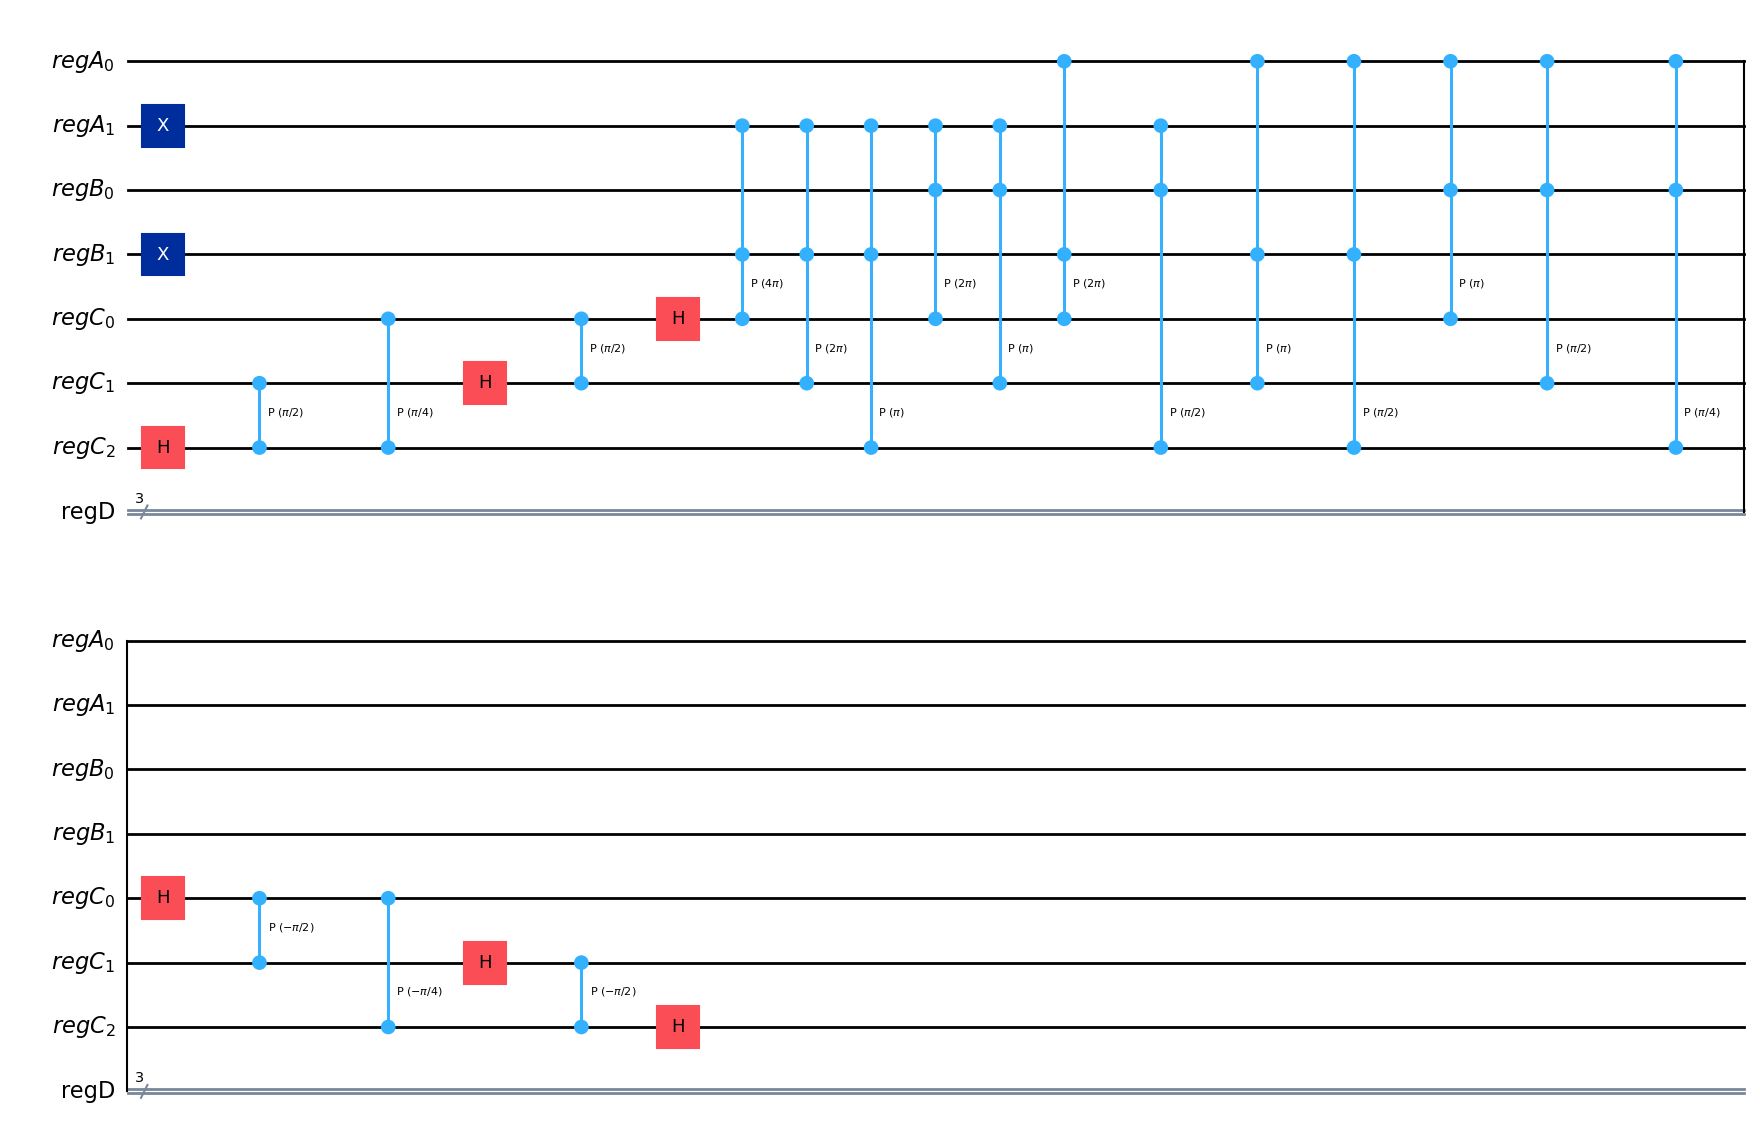

In [34]:
for target in range(maxInputLength + 1):
    qc.h(regC[target])
    for control in range(target+1, maxInputLength + 1):
        qc.cp(-math.pi/(2**(control-target)), regC[control], regC[target])
qc.draw("mpl", plot_barriers=False)

Here are the same circuits but using gates already in qiskit.

In [35]:
"""
#Decomposed to QFT 
qc.append(QFT(outputDigits, do_swaps=False).to_gate(), regC[:])

for j in range(1, maxInputLength + 1):
    for i in range(1, maxInputLength + 1):
        for k in range(1, outputDigits + 1):
            lam = (2 * math.pi) / (2 ** (i + j + k - 2 * maxInputLength))
            qc.append(
                PhaseGate(lam).control(2),
                [regA[maxInputLength - j], regB[maxInputLength - i], regC[k - 1]],
            )
qc.append(QFT(outputDigits, do_swaps=False).inverse().to_gate(), regC[:])
"""

# Prepared gate
#qc.append(RGQFTMultiplier(maxInputLength=maxInputLength, num_result_qubits=outputDigits), qargs=regA[:] + regB[:] + regC[:])

'\n#Decomposed to QFT \nqc.append(QFT(outputDigits, do_swaps=False).to_gate(), regC[:])\n\nfor j in range(1, maxInputLength + 1):\n    for i in range(1, maxInputLength + 1):\n        for k in range(1, outputDigits + 1):\n            lam = (2 * math.pi) / (2 ** (i + j + k - 2 * maxInputLength))\n            qc.append(\n                PhaseGate(lam).control(2),\n                [regA[maxInputLength - j], regB[maxInputLength - i], regC[k - 1]],\n            )\nqc.append(QFT(outputDigits, do_swaps=False).inverse().to_gate(), regC[:])\n'

### 3.3  Measuring and running the simulation
Now that the circuit is fully constructed, we need to simulate it to obtain the results. We measure the `regC` in to `regD`, initialize a quantum simulator, compile our circuit for execution, and let it compute the result.

100


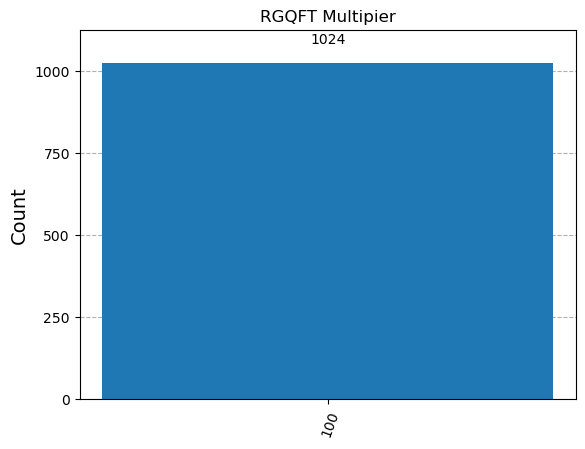

In [36]:
qc.measure(regC, regD)

simulator = AerSimulator()
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
counts = result.get_counts(circ)

print(max(counts, key=counts.get))
plot_histogram(counts, title='RGQFT Multipier')